In [ ]:
# Today, AI is everywhere, we are able to do many things with it.
# I will be exploring one of the key areas within AI, classification, which is a field currently under research, and we have not fully yet found out the limitations
# We've trained AI which can classify animals, plants, cars, and medicine, among other things.
# However, the main problem in hand revolves around the AI's capability to effectively classify manipulated images and the extent of training required to enable the AI to reliably detect these altered images.
# This is where the AI is most vulnerable as it is not able to adapt quickly to evolving image manipulation techniques and this is what I will be aiming to research and come to a solution where I aim to see how easily I can manipulate the AI into classifying the hacked images.


Found 3096 images belonging to 4 classes.
1/1 [==============================] - 0s 59ms/step


<Figure size 1800x800 with 0 Axes>

<Figure size 1800x800 with 0 Axes>

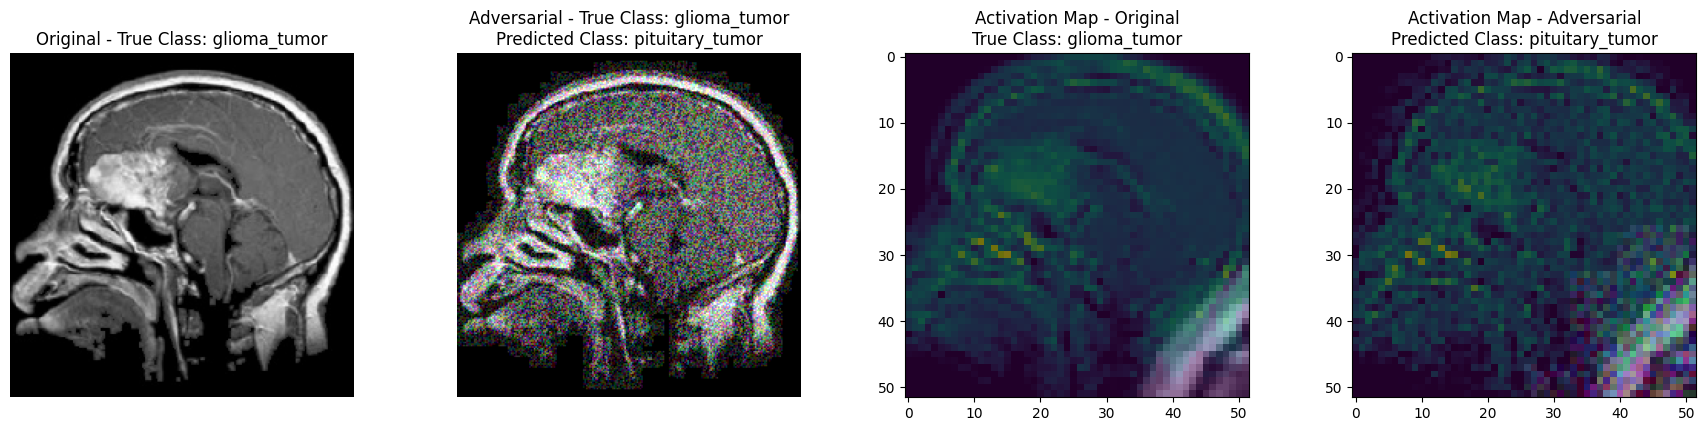

1/1 [==============================] - 0s 57ms/step


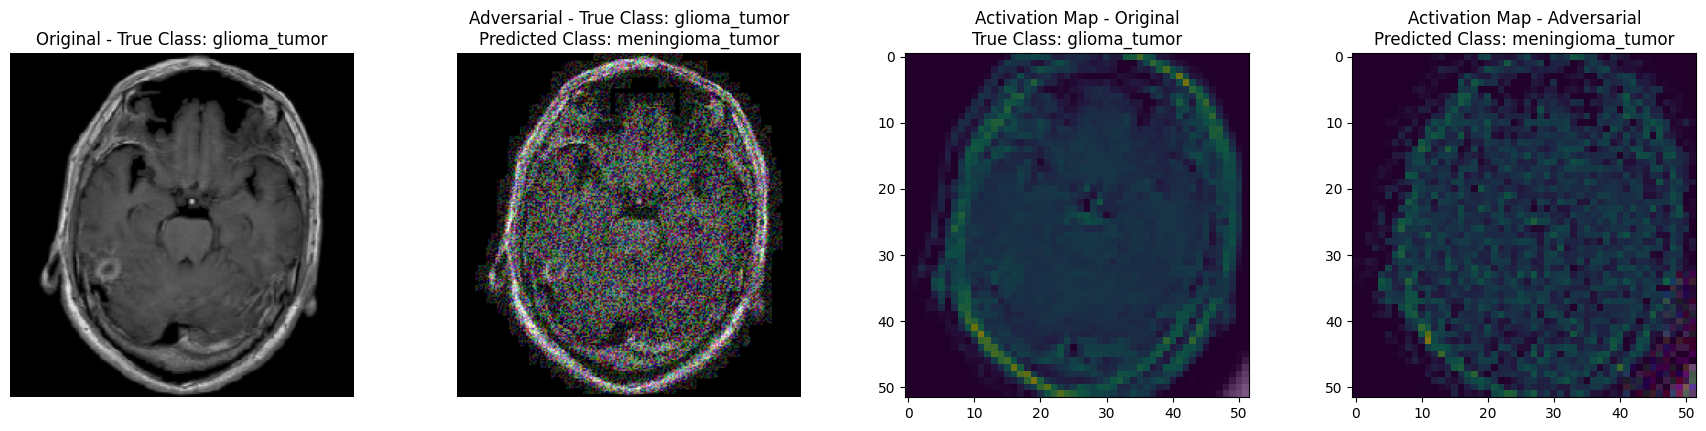

1/1 [==============================] - 0s 57ms/step


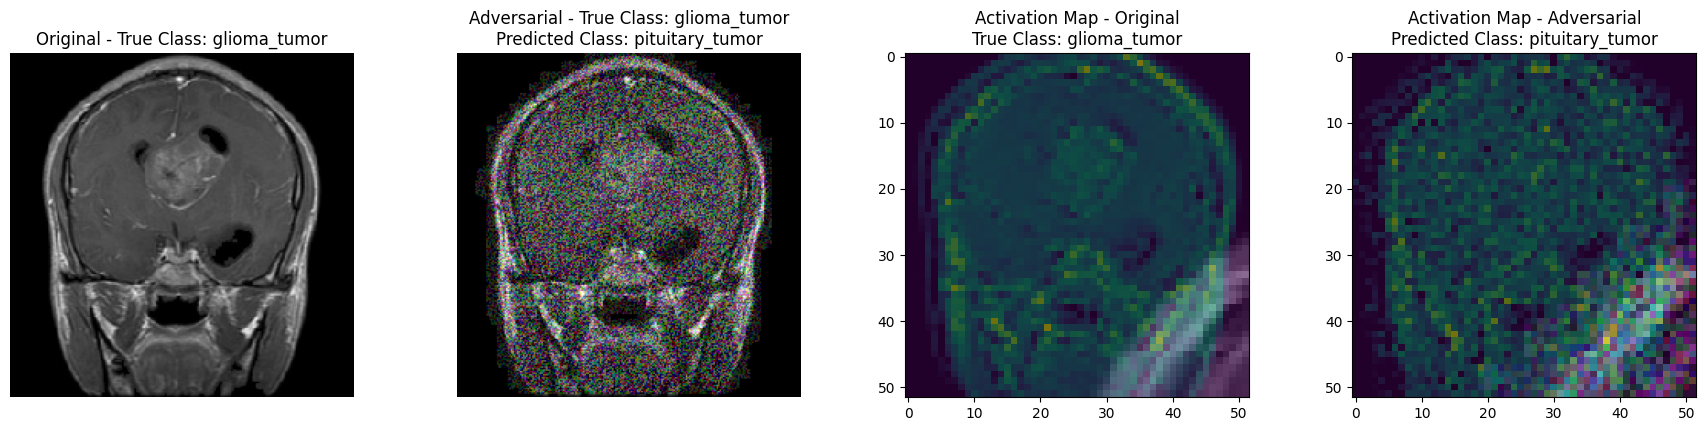

1/1 [==============================] - 0s 56ms/step


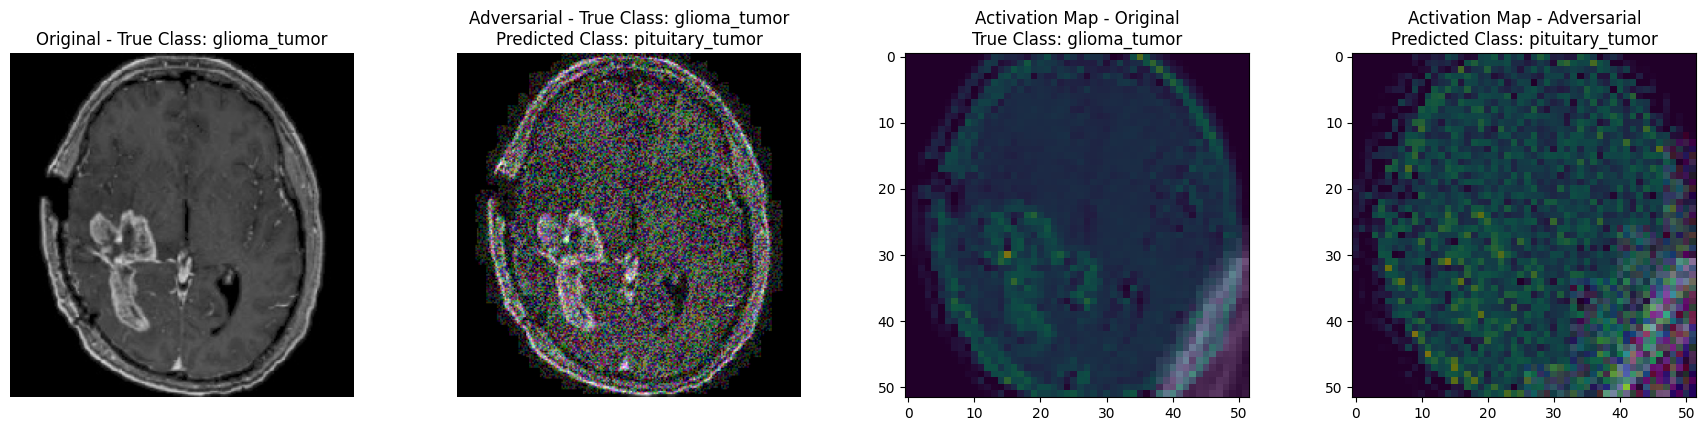

1/1 [==============================] - 0s 60ms/step


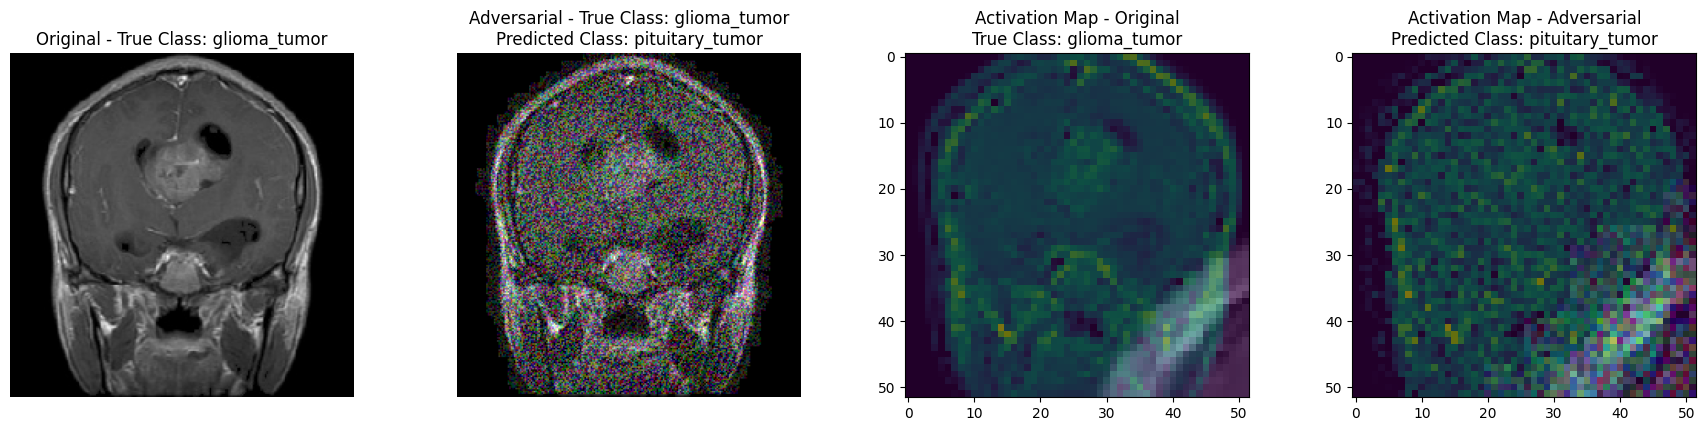

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, layers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import TensorFlowV2Classifier
import tensorflow_datasets as tfds
dataset_path = '/content/drive/MyDrive/Colab Notebooks/Data'
num_classes = len(os.listdir(dataset_path))
test_datagen = ImageDataGenerator(rescale=1./255)
test_dataset = test_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

class_names = test_dataset.class_indices
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
art_classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=num_classes,
    input_shape=(224, 224, 3),
    loss_object=tf.keras.losses.CategoricalCrossentropy(),
)
test_batch = next(iter(test_dataset))
test_images, test_labels = test_batch
test_images_np = test_images
attack = FastGradientMethod(estimator=art_classifier, eps=0.2)
adversarial_test_images = attack.generate(test_images_np, y=test_labels)
def generate_activation_map(model, layer_index, input_image):
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=model.layers[layer_index].output)
    activation = activation_model.predict(input_image[tf.newaxis, ...])
    return activation[0]
layer_index_to_visualize = 4
num_display = 5
plt.figure(figsize=(18, 8))
class_names_inverse = {v: k for k, v in class_names.items()}
for i in range(num_display):
    image_to_visualize_original = test_images[i]
    image_to_visualize_adversarial = adversarial_test_images[i]
    original_label_index = np.argmax(test_labels[i])
    original_label = class_names_inverse[original_label_index]
    activation_map_original = generate_activation_map(model, layer_index_to_visualize, image_to_visualize_original)
    activation_map_adversarial = generate_activation_map(model, layer_index_to_visualize, image_to_visualize_adversarial)
plt.figure(figsize=(18, 8))
for i in range(num_display):
    image_to_visualize_original = test_images[i]
    image_to_visualize_adversarial = adversarial_test_images[i]
    original_label_index = np.argmax(test_labels[i])
    true_class_original = list(class_names.keys())[list(class_names.values()).index(original_label_index)]
    activation_map_original = generate_activation_map(model, layer_index_to_visualize, image_to_visualize_original)
    activation_map_adversarial = generate_activation_map(model, layer_index_to_visualize, image_to_visualize_adversarial)
    plt.figure(figsize=(18, 8))
    plt.subplot(2, 4, 1)
    plt.imshow(image_to_visualize_original)
    plt.title(f'Original - True Class: {true_class_original}')
    plt.axis('off')
    plt.subplot(2, 4, 2)
    plt.imshow(image_to_visualize_adversarial)
    adversarial_predictions = art_classifier.predict(image_to_visualize_adversarial[tf.newaxis, ...])
    predicted_class_adversarial = np.argmax(adversarial_predictions)
    predicted_class_adversarial_label = list(class_names.keys())[list(class_names.values()).index(predicted_class_adversarial)]
    plt.title(f'Adversarial - True Class: {true_class_original}\nPredicted Class: {predicted_class_adversarial_label}')
    plt.axis('off')
    plt.subplot(2, 4, 3)
    plt.imshow(image_to_visualize_original)
    plt.imshow(activation_map_original[:, :, 0], cmap='viridis', alpha=0.5)
    plt.title(f'Activation Map - Original\nTrue Class: {true_class_original}')
    plt.subplot(2, 4, 4)
    plt.imshow(image_to_visualize_adversarial)
    plt.imshow(activation_map_adversarial[:, :, 0], cmap='viridis', alpha=0.5)
    plt.title(f'Activation Map - Adversarial\nPredicted Class: {predicted_class_adversarial_label}')
    plt.tight_layout()
    plt.show()

#Here is my attempt at generating a activation map to see how the AI model is being confused using ART/GAN and which part of image it is confusing, as you can see it is working and it shows which part of image is confusing the AI